　「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第4部第1章 階層ベイズモデルと一般化線形混合モデルの基本」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

　この章では，階層ベイズモデルの基本的な事柄が解説されています。また階層ベイズモデルの具体例として，一般化線形混合モデル（Generalized Linear Mixed Models GLMM）の推定が試みられています。

　本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

　なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです

# 分析の準備
## パッケージの読み込み

In [1]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'
import seaborn as sns

# データの読み込み
## 分析対象のデータ

In [152]:
fish_num_climate_2 = pd.read_csv('4-1-1-fish-num-2.csv')

## id列を数値ではなくfactorとして扱う

In [153]:
fish_num_climate_2['id'] = fish_num_climate_2['id'].astype(object)
fish_num_climate_2.head(n=3)

,fish_num,weather,temperature,id
0,0,cloudy,5.0,1
1,1,cloudy,24.2,2
2,6,cloudy,11.5,3


# 通常のポアソン回帰モデルの当てはめ

## 参考：デザイン行列の作成

In [155]:
# 応答変数の削除とダミー変数化処理
design_mat = pd.get_dummies(fish_num_climate_2.drop(['fish_num'], axis=1),
                            drop_first=True)

# 列名を書籍準拠に
design_mat = design_mat[['weather_sunny', 'temperature']]

# (Intercept)列追加
design_mat.insert(0, '(Intercept)', 1)

display(design_mat)

,(Intercept),weather_sunny,temperature
0,1,0,5.0
1,1,0,24.2
2,1,0,11.5
3,1,0,9.8
4,1,0,18.1
...,...,...,...
95,1,1,7.5
96,1,1,9.7
97,1,1,9.2
98,1,1,5.5


## 参考：データの作成

In [156]:
data_list = dict(N=len(fish_num_climate_2),
                 fish_num=fish_num_climate_2['fish_num'],
                 temp=fish_num_climate_2['temperature'],
                 sunny=design_mat['weather_sunny'])

## ポアソン回帰モデルを作る

In [157]:
# stanコードの記述
stan_code = '''
data {
  int N;                   // サンプルサイズ
  int fish_num[N];         // 釣獲尾数
  vector[N] temp;          // 気温データ
  vector[N] sunny;         // 晴れダミー変数
}

parameters {
  real Intercept;      // 切片
  real temperature;         // 係数(気温)
  real weathersunny;        // 係数(晴れの影響)
}

model {
  vector[N] lambda = exp(Intercept + temperature*temp + weathersunny*sunny);
  fish_num ~ poisson(lambda);
}

generated quantities {
    vector[N] lambda_sunny;
    vector[N] lambda_cloudy;
    
    for(i in 1:N){
        lambda_sunny[i] = exp(Intercept + temperature*temp[i] + weathersunny*1);
        lambda_cloudy[i] = exp(Intercept + temperature*temp[i] + weathersunny*0);
    }
}

'''

# モデルのコンパイル
stan_model = pystan.StanModel(model_code=stan_code)

# サンプリング
glm_pois_brms = stan_model.sampling(data=data_list, seed=1, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6f00b22f8f1bacaae22a7ed5dc2e2b65 NOW.


## 参考：結果の表示

In [158]:
print(glm_pois_brms.stansummary(pars=["Intercept", "temperature", "weathersunny", "lp__"],
                                probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_6f00b22f8f1bacaae22a7ed5dc2e2b65.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd    2.5%    50%  97.5%  n_eff   Rhat
Intercept       0.3  4.0e-3   0.15 -6.5e-3    0.3   0.58   1474    1.0
temperature    0.06  2.0e-4 7.7e-3    0.05   0.06   0.08   1483    1.0
weathersunny  -0.73  2.8e-3   0.13    -1.0  -0.73  -0.47   2324    1.0
lp__          33.94    0.03   1.25   30.66  34.26  35.36   1289    1.0

Samples were drawn using NUTS at Tue Sep 15 21:06:04 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 結果の図示

In [159]:
mcmc_sample = glm_pois_brms.extract()

In [160]:
result  = poisson.pmf(15,mcmc_sample['lambda_cloudy'])
# 空のデータフレームを作成
result_prob_solar = pd.DataFrame(np.zeros([len(fish_num_climate_2), 3])) 
result_prob_shade = pd.DataFrame(np.zeros([len(fish_num_climate_2), 3])) 

# 2.5・50・97.5パーセンタイルの値をデータフレームに代入
for i in range(len(fish_num_climate_2)):
    result_prob_solar.iloc[i,:] = np.percentile(poisson.rvs(mcmc_sample['lambda_cloudy'], size= (4000, 100))[:,i], q=[2.5, 50, 97.5])
    result_prob_shade.iloc[i,:] = np.percentile(poisson.rvs(mcmc_sample['lambda_sunny'], size= (4000, 100))[:,i], q=[2.5, 50, 97.5])
    
# データフレームの列名を変更
result_prob_solar.columns = ["2.5%", "50%", "97.5%"]
result_prob_shade.columns = ["2.5%", "50%", "97.5%"]

# 栄養素情報をデータフレームに追加
result_prob_solar['temperature'] = fish_num_climate_2['temperature']
result_prob_shade['temperature'] = fish_num_climate_2['temperature']

# 栄養素情報で並び順をソート
result_prob_solar = result_prob_solar.sort_values('temperature')
result_prob_shade = result_prob_shade.sort_values('temperature')

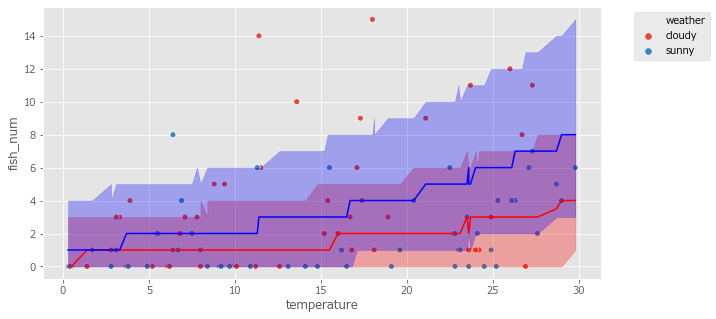

In [164]:
# 種子個数
binom_size = 10

# グラフ描画領域の作成
plt.figure(figsize=(10, 5))

# 散布図の描画
sns.scatterplot(x='temperature',
                y='fish_num',
                data=fish_num_climate_2,
                hue='weather')

# 日照がない日の回帰曲線の描画
plt.plot(result_prob_shade['temperature'],
         result_prob_shade["50%"],
         color='red')
# 95%ベイズ信頼区間を描画
plt.fill_between(x=result_prob_shade['temperature'],
                 y1=result_prob_shade["2.5%"],
                 y2=result_prob_shade["97.5%"],
                 color='red',
                 alpha=0.3)

# 日照がある日の回帰曲線の描画
plt.plot(result_prob_solar['temperature'],
         result_prob_solar["50%"],
         color='blue')
# 95%ベイズ信頼区間を描画
plt.fill_between(x=result_prob_solar['temperature'],
                 y1=result_prob_solar["2.5%"],
                 y2=result_prob_solar["97.5%"],
                 color='blue',
                 alpha=0.3)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# グラフの描画
plt.show()

In [133]:
mcmc_sample['lambda_cloudy'].mean(axis=0)

array([1.37724647, 1.38548661, 1.39377692, 1.47069938, 1.49728915,
       1.5990415 , 1.5990415 , 1.62799442, 1.62799442, 1.64759217,
       1.68751094, 1.69764351, 1.70783798, 1.81327354, 1.81327354,
       1.82417494, 1.83514303, 1.84617822, 1.87969059, 1.94858432,
       1.96031394, 1.98398915, 1.98398915, 2.02004866, 2.0322161 ,
       2.04445811, 2.0691677 , 2.11950236, 2.15806948, 2.18417683,
       2.18417683, 2.23735969, 2.23735969, 2.23735969, 2.29186049,
       2.33362094, 2.34771245, 2.37615573, 2.41947946, 2.43409858,
       2.47849741, 2.6009656 , 2.64846298, 2.66449075, 2.68061721,
       2.69684296, 2.88206033, 2.97047863, 3.06165756, 3.15568479,
       3.29228086, 3.37302088, 3.41414328, 3.43489535, 3.54059649,
       3.58379794, 3.64960771, 3.69416251, 3.71664697, 3.78493909,
       3.83117494, 3.85450787, 3.99757292, 4.02193697, 4.02193697,
       4.2223674 , 4.27404354, 4.40606633, 4.62598887, 4.82756684,
       5.25794351, 5.32253498, 5.35513271, 5.35513271, 5.42093